In [3]:
import math, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [ ]:
def prepare_data (location: str) -> pd.DataFrame:
    """Return pandas dataframe with proper labeled columns and adjusted
    values.

    Args:
        location (str): The location directory in string form.

    Returns:
        pd.DataFrame: data file -> pandas dataframe
    """
    cols = ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']
    df = pd.read_csv(location, names=cols, sep=r'\s+')
    df['pos_i'] = df['pos_i'] // 1000000
    df['pos_j'] = df['pos_j'] // 1000000
    return df

In [5]:
def find_chr_length (data: pd.DataFrame) -> dict[str: tuple]:
    """Return a dictionary containing each unique chromosome mapped to their lengths
    as a tuple (min_length, max_length).
    
    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: chromosome -> length (min, max)
    """
    chr_bounds = {}
    chromosomes = sorted(set(data['chr_i']).union(data['chr_j']))
    for chr_ in chromosomes:
            max_i = data.loc[data['chr_i'] == chr_, 'pos_i'].max()
            max_j = data.loc[data['chr_j'] == chr_, 'pos_j'].max()
            min_i = data.loc[data['chr_i'] == chr_, 'pos_i'].min()
            min_j = data.loc[data['chr_j'] == chr_, 'pos_j'].min()
            chr_bounds[chr_] = (min(min_i, min_j), max(max_i, max_j))
    return chr_bounds

In [6]:
def build_chr_block_matrix(data: pd.DataFrame) -> pd.DataFrame:
    """Return a DataFrame where rows and columns are chromosomes and
    each cell contains a symmetric contact matrix (DataFrame) between those chromosomes.

    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        pd.DataFrame: block DataFrame of contact matrices
    """
    # compute length of chromosome
    chr_bounds = find_chr_length(data)
    chromosomes = sorted(set(data['chr_i']).union(data['chr_j']))

    # initialize the block matrix as pandas dataframe
    chr_block_df = pd.DataFrame(index=chromosomes, columns=chromosomes, dtype=object)

    # fill each block/cell with sub contact matrices
    for chr_i in chromosomes:
        for chr_j in chromosomes:
            # set lengths for chromosome contact matrix
            min_i, max_i = chr_bounds[chr_i]
            min_j, max_j = chr_bounds[chr_j]
            row_bins = list(range(min_i, max_i + 1))
            col_bins = list(range(min_j, max_j + 1))

            # initialize zero matrix
            mat = pd.DataFrame(0, index=row_bins, columns=col_bins)

            # find subset of actual contact data for this chr pair
            subdf = data[(data['chr_i'] == chr_i) & (data['chr_j'] == chr_j)]

            # _ is just to run this loop and row represents the rows of data where contact occurs
            for _, row in subdf.iterrows():
                i, j = row['pos_i'], row['pos_j']
                mat.at[i, j] = row['contacts']
                # add symmetric entry if same chromosome
                if chr_i == chr_j:
                    mat.at[j, i] = row['contacts']
                    
            # set the contact matrix into the block matrix
            chr_block_df.at[chr_i, chr_j] = mat

    return chr_block_df

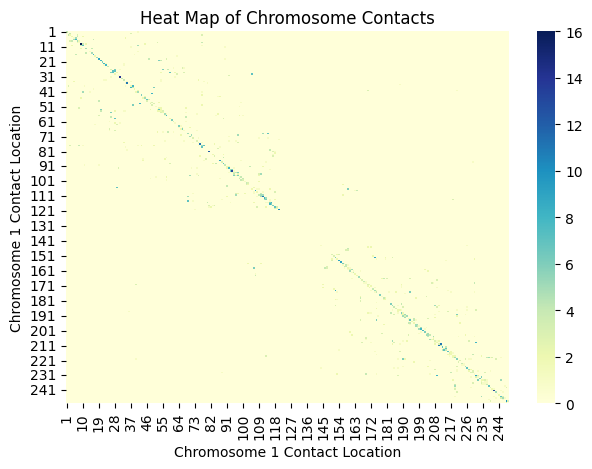

In [7]:
df = prepare_data('/Users/salah/Documents/chromosome-prediction/data/HAP1/ml1_AAGCCGGT-ATACATGT.txt')
matrix = build_chr_block_matrix(df)

sns.heatmap(matrix.at['chr1', 'chr1'], cmap='YlGnBu')
plt.title("Heat Map of Chromosome Contacts")
plt.xlabel("Chromosome 1 Contact Location")
plt.ylabel("Chromosome 1 Contact Location")
plt.tight_layout()
plt.show()

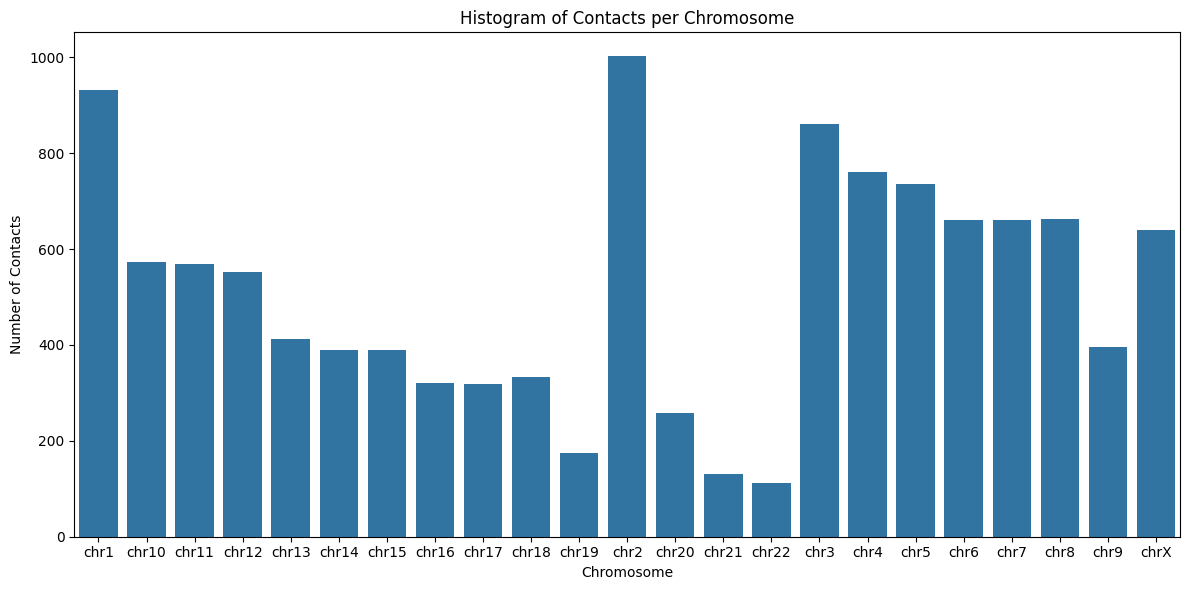

In [8]:
def sum_contacts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Count total number of contacts per chromosome from both chr_i and chr_j.
    
    Args:
        df (pd.DataFrame): DataFrame with columns ['chr_i', 'chr_j']

    Returns:
        pd.Dataframe: chromosome -> number of contacts
    """
    counts_i = df['chr_i'].value_counts()
    counts_j = df['chr_j'].value_counts()
    
    total_counts = counts_i.add(counts_j, fill_value=0).astype(int)
    total_df = total_counts.reset_index()
    total_df.columns = ['chromosome', 'total_contacts']

    return total_df.sort_values(by='chromosome')

contact_count = sum_contacts(df)
plt.figure(figsize=(12, 6))
sns.barplot(x='chromosome', y='total_contacts', data=contact_count)
plt.title("Histogram of Contacts per Chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Number of Contacts")
plt.tight_layout()
plt.show()

In [9]:
def cell_summary_stats(data: pd.DataFrame) -> dict:
    """Return a dictionary containing summary statistics of the cell.

    Args:
        df (pd.DataFrame): contact data with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: feature_name -> value
    """
    total_contacts = data['contacts'].sum()
    mean_contact = data['contacts'].mean()
    var_contact = data['contacts'].var()
    max_contact = data['contacts'].max()

    features = {
        'total_cell_contact': float(total_contacts),
        'mean_cell_contact': float(mean_contact),
        'var_cell_contact': float(var_contact),
        'max_contact': float(max_contact),
    }
    return features

In [10]:
def chr_contact_stats(matrix: pd.DataFrame) -> dict:
    """Return a dictionary containing chromosomes mapped to it's summary
    statistics (total contact, mean contacts, varience contacts).
    
    Args:
        df (pd.DataFrame): block matrix with diagonal contact matrices
    
    Returns:
        dict: chromosome -> contact_stats (total_contact, mean_contact, contact_var)
    """
    chr_diagonal = {}
    
    for chr in matrix.index:
        chr_diagonal[chr] = matrix.at[chr, chr]
        
    diagonal_stats = {}
    
    for chr in chr_diagonal:
        diagonal = np.diag(chr_diagonal[chr])
        diagonal_stats[chr] = (float(diagonal.sum()), float(diagonal.mean()), 
                               float(diagonal.var()))
    return diagonal_stats

In [11]:
hap1stats = cell_summary_stats(df)

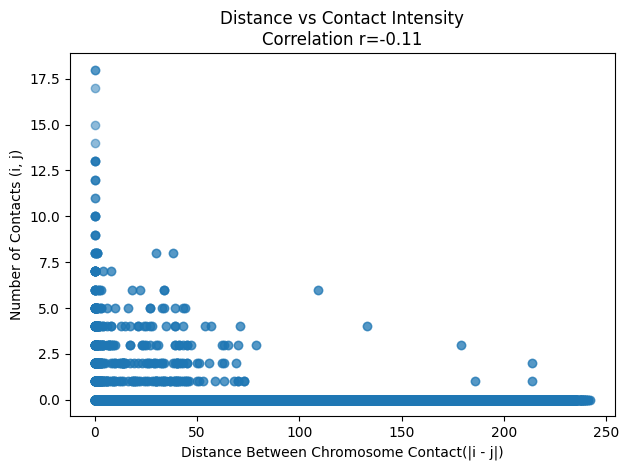

In [12]:
def calculate_dist_contact(matrix: pd.DataFrame) -> dict:
    """
    Compute distance-from-diagonal vs contact intensity for a symmetric matrix.

    Args:
        matrix (pd.DataFrame): contact matrix (e.g., chr3 vs chr3)

    Returns:
        dict: {
            'distances': list of |i - j| (distance between contact points),
            'contacts': list of contacts,
            'correlation': Pearson correlation (distance vs contact)
        }
    """
    distances = []
    contacts = []

    idx_to_pos = list(matrix.index)
    col_to_pos = list(matrix.columns)

    for i, row_pos in enumerate(idx_to_pos):
        for j, col_pos in enumerate(col_to_pos):
            contact = matrix.iat[i, j] # The contact on the i, j position
            dist = abs(i - j) # distance from position i to j
            distances.append(dist)
            contacts.append(contact)

    # Correlation analysis
    corr, _ = pearsonr(distances, contacts) # calculate linear correlation

    return {'distances': distances, 'contacts': contacts, 
            'correlation': corr}

contact_matrix = matrix.at['chr2', 'chr2'] 
dist_contact = calculate_dist_contact(contact_matrix)

plt.scatter(dist_contact['distances'], dist_contact['contacts'], alpha=0.5)
plt.title(f"Distance vs Contact Intensity\nCorrelation r={dist_contact['correlation']:.2f}")
plt.xlabel("Distance Between Chromosome Contact(|i - j|)")
plt.ylabel("Number of Contacts (i, j)")
plt.tight_layout()
plt.show()

In [13]:
def read_all_in_cell_type(folder_path: str, file_suffix: str=".txt") -> pd.DataFrame:
    """
    Loop through all cell files in a folder and extract features.

    Args:
        folder_path (str): Path to directory with cell contact files.
        file_suffix (str): File extension to filter on.

    Returns:
        pd.DataFrame: One row per cell, columns are features.
    """
    cells = []
    
    for fname in os.listdir(folder_path):
        if fname.endswith(file_suffix):
            cell_id = os.path.splitext(fname)[0]
            cell_path = os.path.join(folder_path, fname)
            
        try:
            features = {'cell_id': cell_id}
            df = prepare_data(location=cell_path)
            features['block_matrix'] = build_chr_block_matrix(df)
            features.update(cell_summary_stats(df))
            features.update(chr_contact_stats(features["block_matrix"]))
            cells.append(features)
        except Exception as error:
            print(f"Exception raised for {fname} due to error: {error}")
    return pd.DataFrame(data=cells).set_index('cell_id')

gm_12878 = read_all_in_cell_type(folder_path='/Users/salah/Documents/chromosome-prediction/data/GM12878')
# hap_1 = read_all_in_cell_type(folder_path='/Users/salah/Documents/chromosome-prediction/data/HAP1')
# hela = read_all_in_cell_type(folder_path='/Users/salah/Documents/chromosome-prediction/data/Hela')
k_562 = read_all_in_cell_type(folder_path='/Users/salah/Documents/chromosome-prediction/data/K562')

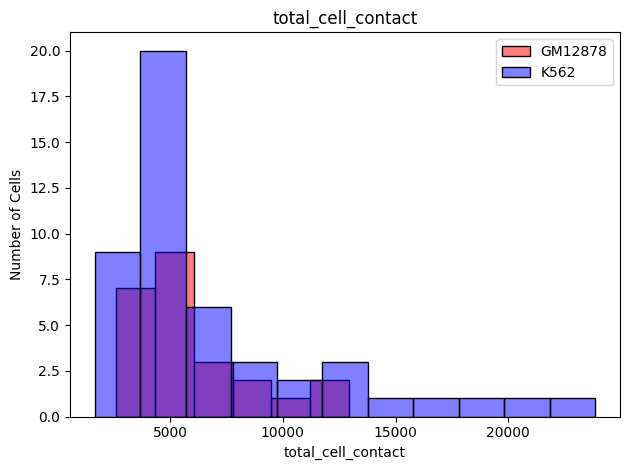

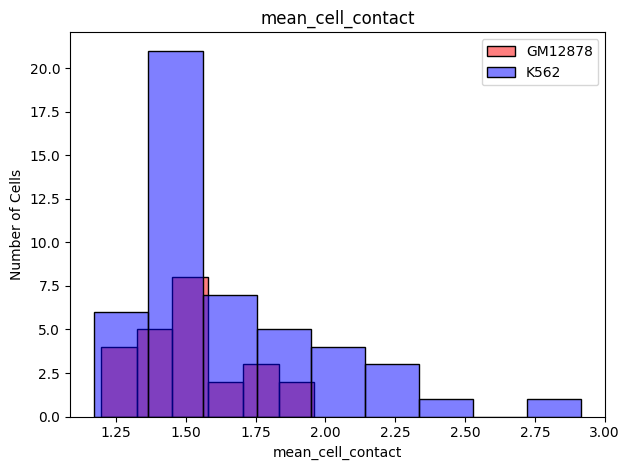

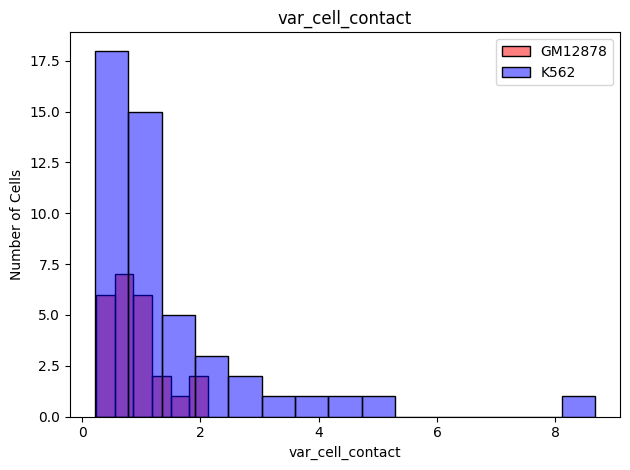

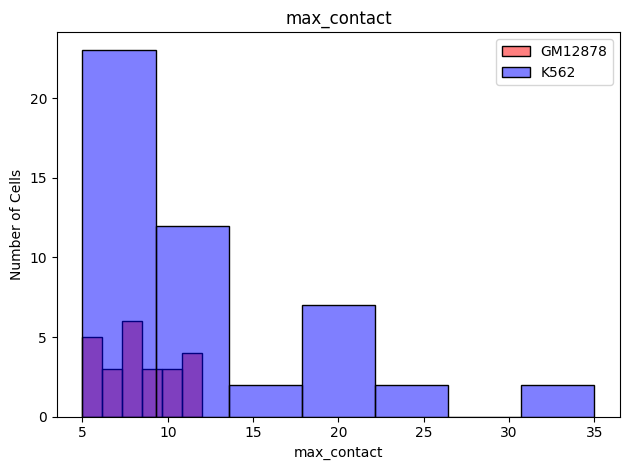

In [18]:
cols = ['total_cell_contact',  'mean_cell_contact', 'var_cell_contact', 'max_contact']

for label in cols:
    sns.histplot(gm_12878[label], color='red', alpha=0.5, label='GM12878')
    sns.histplot(k_562[label], color='blue', alpha=0.5, label='K562')
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('Number of Cells')
    plt.legend()
    plt.tight_layout()
    plt.show()